# Replicate QST article sims

### 1. Red sideband Hamiltonian

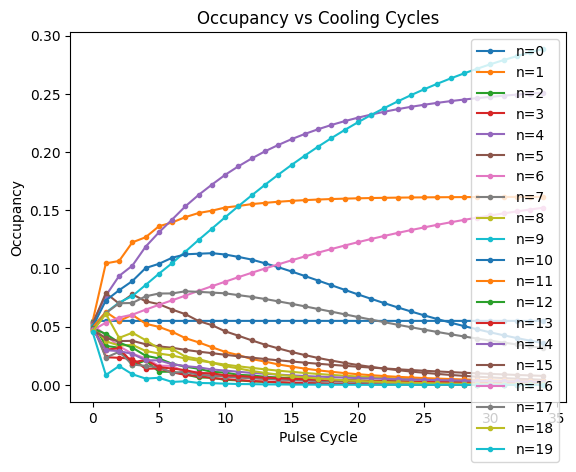

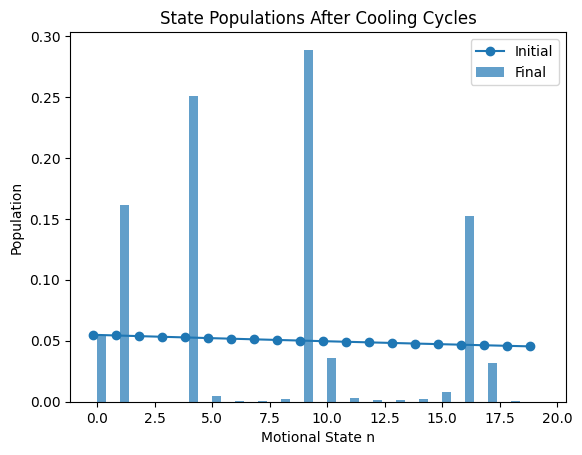

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1.0  # Detuning
nu = 1.0     # Motional frequency
Omega=.01  # Rabi frequency
eta = 0.02    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 0.005  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration
tg = 200 # Dissipation duration (time gap)

# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))

# Hamiltonian (Red Sideband for Pulse)
H_pulse = 1j*eta*Omega/2 * (a_full* s_plus_full - a_dag_full * s_minus_full)
# Hamiltonian (Free evolution for Dissipation) - Assuming H0 during dissipation phase? 
# For now, let's assume H_diss = 0 for the dissipative step relative to the rotating frame.
H_diss = gamma * s_z_full 

# --- Collapse Operators for Dissipation ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / sum(W)
G = gamma / 2 

c_ops = []
for i, c in enumerate(cosal):
    op = tensor(s_minus, (1j * c * eta * xop).expm())
    c_ops.append(np.sqrt(2 * G * W[i]) * op)

# --- Construct Liouvillians ---
# 1. Pulse Step: Coherent RSB drive, NO dissipation (or minimal?)
# Typically only Unitary part active during pulse
L_pulse = liouvillian(H_pulse, []) 

# 2. Dissipation Step: No Drive, ONLY Dissipation (Optical Pumping)
# H = 0 (or H0), c_ops active
L_diss = liouvillian(H_diss, c_ops)

# --- Propagators ---
# Propagator for Pulse step (duration tau)
prop_pulse = (L_pulse * tau).expm()

# Propagator for Dissipation step (duration tg)
prop_diss = (L_diss * tg).expm()

# Combined Propagator for one cycle (Pulse -> Dissipation)
prop_cycle = prop_diss * prop_pulse 


# --- Simulation ---
num_pulses = 34 # Number of cycles
times_sim = np.arange(num_pulses + 1) # Just integer steps for cycles

# Initial state
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr() 
ground_state = basis(2, 1) 
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec
    
    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies[0, :]
p_motional_final = occupancies[-1, :]
plt.figure()
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles')
plt.legend()
plt.show()

### Complete Hamiltonian

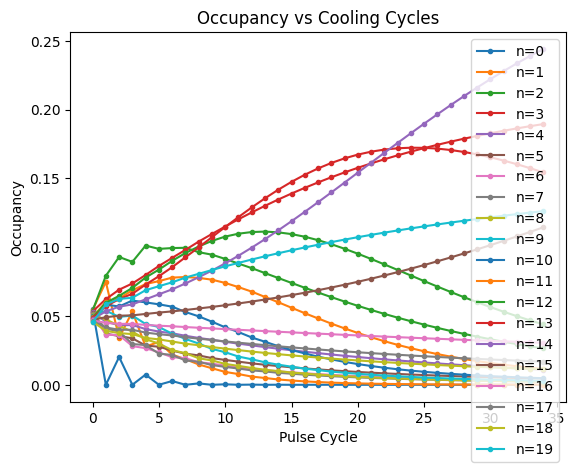

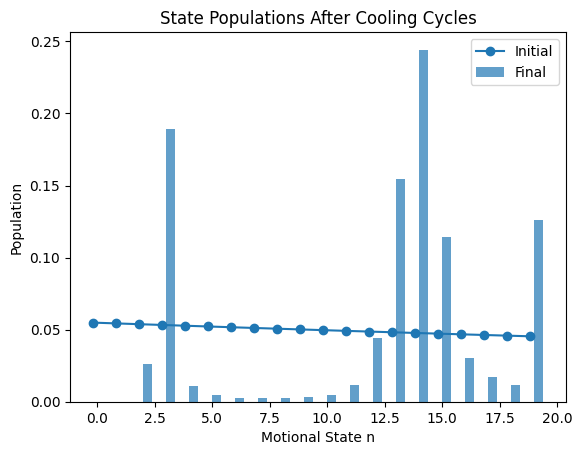

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1.0  # Detuning
nu = 1.0     # Motional frequency
Omega=.01  # Rabi frequency
eta = 0.02    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 0.005  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration
tg = 200 # Dissipation duration (time gap)

# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()
sy = sigmay()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))
s_x_full = tensor(sigmax(), qeye(N))
s_y_full = tensor(sy, qeye(N))

# New Hamiltonian (Red Sideband for Pulse)
# H' = i*Omega*eta/2 * [sigma_x * (a_dag + a)]
H_pulse = 1j * eta * Omega / 2 * s_x_full * (a_dag_full + a_full)

# Hamiltonian (Free evolution for Dissipation)
H_diss = gamma * s_z_full 

# --- Collapse Operators for Dissipation ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / sum(W)
G = gamma / 2 

c_ops = []
for i, c in enumerate(cosal):
    op = tensor(s_minus, (1j * c * eta * xop).expm())
    c_ops.append(np.sqrt(2 * G * W[i]) * op)

# --- Construct Liouvillians ---
# Dissipation Step: No Drive, ONLY Dissipation (Optical Pumping)
L_diss = liouvillian(H_diss, c_ops)

# --- Propagators ---

# Pulse Sequence Construction
# 1. Displacement D(alpha) with alpha = i*eta/2
alpha = 1j * eta / 2 # Assuming 'e' meant 2 or standard polaron displacement
D_alpha = tensor(qeye(2), displace(N, alpha))
H_original = Omega*a_dag_full*a_full + Omega/2*(s_plus_full * D_alpha + s_minus_full * D_alpha.dag()) 

# 2. Y pulse for pi/2: R_y(pi/2) = exp(-i * pi/4 * sigma_y)
U_y = tensor((-1j * (np.pi / 4) * sy).expm(), qeye(N))

# 3. Unitary X pulse for length tau: U_pulse = exp(-i * H_pulse * tau)
U_pulse_tau = (-1j * H_original * tau).expm()

# Sequence: D -> Y(pi/2) -> U_x(tau) -> Y(-pi/2) -> D(-alpha)
# Note: Operators apply from right to left on the state ket, or U rho U_dag
# U_seq = D_dag * U_y_dag * U_pulse_tau * U_y * D
# To undo Y (pi/2), we apply Y(-pi/2) which is U_y.dag()
# To undo D (alpha), we apply D(-alpha) which is D_alpha.dag()

U_seq = D_alpha * U_y * U_pulse_tau * U_y.dag() * D_alpha.dag()

# Convert to superoperator for the unitary part
prop_unitary = to_super(U_seq)

# Propagator for Dissipation step (duration tg)
prop_diss = (L_diss * tg).expm()

# Combined Propagator for one cycle (Pulse Sequence -> Dissipation)
prop_cycle = prop_diss * prop_unitary 


# --- Simulation ---
num_pulses = 34 # Number of cycles
times_sim = np.arange(num_pulses + 1) # Just integer steps for cycles

# Initial state
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr() 
ground_state = basis(2, 1) 
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec
    
    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies[0, :]
p_motional_final = occupancies[-1, :]
plt.figure()
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles')
plt.legend()
plt.show()